# Scan analysis - shap

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [124]:
import pandas as pd

import itertools

from tqdm import tqdm

import seaborn as sns

from math import floor


from matplotlib.colors import BoundaryNorm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from xgboost import XGBRegressor
import shap


from plots2.fns import (
    get_corner_annotations,
    get_corner_annotations_custom_labels
)


from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
    SHAP_BLUE,
)

from poly2.utils import (
    get_dispersal_kernel, trait_vec, beta_dist, gamma_dist,
    get_dist_var, get_dist_mean, edge_values
)
from poly2.shap import get_shap_values
from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote
from poly2.consts import FUNG_DECAY_RATE, MUTATION_PROP, MUTATION_SCALE

In [3]:
df = pd.read_csv('../outputs/combined/scan_all.csv')

In [4]:
df_use = df.loc[lambda x: (x.run<8000)]

X = (
    df_use
    .drop([
        'best_dose',
        'n_pos_diff',
        'ME_var',
        'run',
    ], axis=1)
    .filter(regex='^((?!in_0).)*$')
    .rename(columns = {
        'dec_rate_multiplier': 'dec_rate',
        'm_prop_multiplier': 'm_prop',
        'm_scale_multiplier': 'm_scale',
        'asymptote': 'asymp',
    })
)

# y = df_use.loc[:, ['run', 'best_dose']]

In [5]:
X.head()

,year,mu,b,asymp,dec_rate,m_prop,m_scale,ME_mean
0,1,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
1,2,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
2,3,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
3,4,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
4,5,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241


# Fig 4

In [6]:
HEIGHT = 4
WIDTH = 8

MAX_DISPLAY = 8

In [7]:
plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title

## Identify model runs

In [12]:
tidy_df = (
    df
    .filter(regex='^((?!in_0).)*$')
    .drop(['n_pos_diff', 'ME_var'], axis=1)
    .rename(columns = {
        'dec_rate_multiplier': 'dec_rate',
        'm_prop_multiplier': 'm_prop',
        'm_scale_multiplier': 'm_scale',
        'asymptote': 'asymp',
    })
)

tidy_df.head()

,run,year,best_dose,mu,b,asymp,dec_rate,m_prop,m_scale,ME_mean
0,0,1,1.0,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
1,0,2,1.0,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
2,0,3,1.0,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
3,0,4,1.0,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
4,0,5,1.0,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241


In [45]:
Config()

CONFIG
------
I0s = [0.00985703, 0.00985703, 0.00985703, 0.00985 ...
asymptote = None
betas = [0.00786542, 0.00786542, 0.00786542, 0.007 ...
decay_rate = None
doses = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1 ...
fungicide_mixture = False
host_on = None
k_b = 0.8431572316700577
k_mu = 9.44286788381916
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019836158401698102
mutation_scale_host = 0.0019836158401698102
n_k = 50
n_l = 50
n_years = 15
replace_cultivars = None
sprays = None



In [57]:
(
    tidy_df
    .loc[lambda x: (
        (x.ME_mean<0.1) &
        (x.dec_rate<1.5) &
        (x.dec_rate>0.5) &
        (x.mu<15) &
        # (x.mu>5) &
        # (x.asymp>012) &
        (x.m_prop>5) &
        # (x.m_prop>0.5) &
        (x.m_scale<1.1)
        # (x.m_scale>0.9)
    )]
    # .run.unique()
    
    .loc[lambda x: x.run==391]
    .head(35)
    
)

,run,year,best_dose,mu,b,asymp,dec_rate,m_prop,m_scale,ME_mean
13685,391,1,1.0,3.578303,2.439441,0.959639,0.920329,9.094288,0.179824,0.088204
13686,391,2,1.0,3.578303,2.439441,0.959639,0.920329,9.094288,0.179824,0.088204
13687,391,3,1.0,3.578303,2.439441,0.959639,0.920329,9.094288,0.179824,0.088204
13688,391,4,1.0,3.578303,2.439441,0.959639,0.920329,9.094288,0.179824,0.088204
13689,391,5,1.0,3.578303,2.439441,0.959639,0.920329,9.094288,0.179824,0.088204
13690,391,6,1.0,3.578303,2.439441,0.959639,0.920329,9.094288,0.179824,0.088204
13691,391,7,1.0,3.578303,2.439441,0.959639,0.920329,9.094288,0.179824,0.088204
13692,391,8,1.0,3.578303,2.439441,0.959639,0.920329,9.094288,0.179824,0.088204
13693,391,9,1.0,3.578303,2.439441,0.959639,0.920329,9.094288,0.179824,0.088204
13694,391,10,1.0,3.578303,2.439441,0.959639,0.920329,9.094288,0.179824,0.088204


459, 1626, 3961, 6856, 9382

## Run these

In [133]:
def get_data(run):
    pars = (
        tidy_df
        .loc[lambda x: x.run==run]
        .head(1)
        .drop(['best_dose', 'year', 'run'], axis=1)
    )

    n_years = 35

    cf = Config(
        n_years=n_years,
        n_k=300,
        verbose=False
    )

    cf.k_mu = pars.mu.values[0]
    cf.k_b = pars.b.values[0]
    cf.asymptote = pars.asymp.values[0]
    cf.decay_rate = FUNG_DECAY_RATE * pars.dec_rate.values[0]
    cf.mutation_proportion = MUTATION_PROP * pars.m_prop.values[0]
    cf.mutation_scale_fung = MUTATION_SCALE * pars.m_scale.values[0]
    
    line_df = pd.DataFrame()

    for dose in tqdm(np.linspace(0.1, 1, 10)):

        cf.doses = dose*np.ones(cf.n_years)

        sim = SimulatorOneTrait(cf)

        data = sim.run_model()
        
        doses = np.repeat(dose, n_years+1)
        #         np.concatenate([
        #             [np.nan],

        #         ])
        
        ylds = np.concatenate([
            [np.nan], 
            data['yield_vec']
        ])

        tmp = pd.DataFrame(
            dict(
                dose=doses,
                yld=ylds,
                fung_mean=data['fung_mean'],
                year=np.arange(0, 1+n_years),
            )
        )

        line_df = pd.concat([line_df, tmp])
    return line_df

In [134]:
%%time

line_df1 = get_data(459)
line_df2 = get_data(1100)
line_df3 = get_data(7708)
line_df4 = get_data(391)

line_df1.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:39<00:00, 27.95s/it]

Wall time: 17min 28s


,dose,yld,fung_mean,year
0,0.1,NaN,0.001667,0
1,0.1,10.226305,0.001676,1
2,0.1,10.226254,0.001709,2
3,0.1,10.226084,0.001829,3
4,0.1,10.225491,0.002285,4


In [149]:
(
    tidy_df
    .loc[lambda x: x.run.isin([459, 1100, 7708, 391])]
    .groupby('run')
    .first()
    .loc[[459, 1100, 7708, 391]]
    .round(4)
    .T
)

run,459,1100,7708,391
year,1.0000,1.0000,1.0000,1.0000
best_dose,1.0000,1.0000,1.0000,1.0000
mu,15.1536,0.4869,10.5543,3.5783
b,2.3984,0.9013,0.6473,2.4394
asymp,0.9825,0.4632,0.9398,0.9596
dec_rate,0.3906,2.2665,1.3121,0.9203
m_prop,1.0802,0.6925,0.7405,9.0943
m_scale,0.9409,0.9351,6.8263,0.1798
ME_mean,0.0191,0.8706,0.0630,0.0882


In [135]:
def bd_use(line_df, yy):
    best_dose = (
        line_df
        .reset_index(drop=True)
        .loc[lambda x: x.year>0]
        .groupby('year')
        .apply(lambda x: x.loc[x.yld.idxmax()])
        .assign(yy=yy)
        .reset_index(drop=True)
        .loc[:, ['dose', 'year', 'yy']]
    )

    eps = 0.1

    out = (
        pd.concat([
            best_dose.assign(year=lambda x: x.year - eps),
            best_dose.assign(year=lambda x: x.year + eps),
        ])
        .drop_duplicates()
        .sort_values('year')
    )
    
    return out

In [152]:
bd_use1 = bd_use(line_df1, 10.7)
bd_use2 = bd_use(line_df2, 8.962)
bd_use3 = bd_use(line_df3, 10.55)
bd_use4 = bd_use(line_df4, 10.55)

## Fig

Wall time: 7.02 s


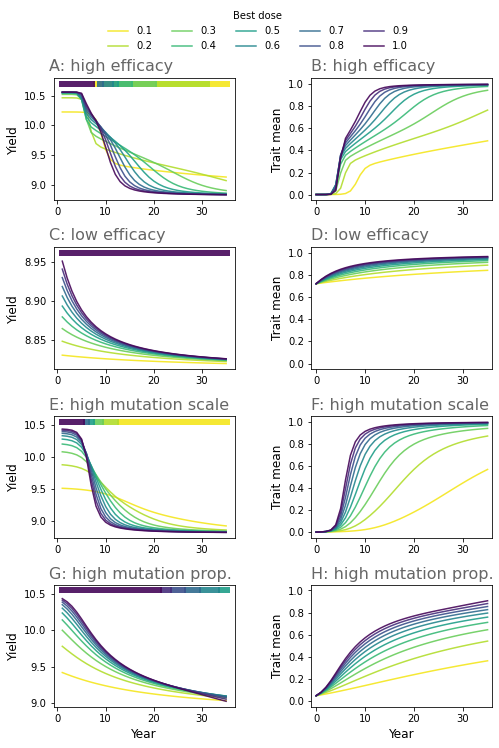

In [153]:
%%time

plt.close('all')

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_FONT)  # fontsize of the figure title


f, ax = plt.subplots(4, 2, figsize=(8, 10))

alpha = 0.9
COLZ = sns.color_palette('viridis_r', n_colors=60)

# DATA

doses = line_df1.dose.unique()

# A
for ind, dose in enumerate(doses):
    
    # if np.isnan(dose):
    #     continue

    n_d = len(doses)
    
    col_ind = floor(ind*59/(-1+n_d))
    
    colr = COLZ[col_ind]
    
    # A
    ax[0][0].plot(line_df1.loc[lambda x: x.dose==dose].year,
            line_df1.loc[lambda x: x.dose==dose].yld,
            label=f'{dose:.1f}',
            alpha=alpha,
            c=colr)
    
    ax[0][0].plot(bd_use1.loc[lambda x: x.dose==dose].year,
            bd_use1.loc[lambda x: x.dose==dose].yy,
            c=colr,
            alpha=alpha,
            lw=6)
    
    # C
    ax[1][0].plot(line_df2.loc[lambda x: x.dose==dose].year,
            line_df2.loc[lambda x: x.dose==dose].yld,
            alpha=alpha,
            c=colr)
    
    ax[1][0].plot(bd_use2.loc[lambda x: x.dose==dose].year,
            bd_use2.loc[lambda x: x.dose==dose].yy,
            c=colr,
            alpha=alpha,
            lw=6)
    
        
    # E
    ax[2][0].plot(line_df3.loc[lambda x: x.dose==dose].year,
            line_df3.loc[lambda x: x.dose==dose].yld,
            alpha=alpha,
            c=colr)
    
    ax[2][0].plot(bd_use3.loc[lambda x: x.dose==dose].year,
            bd_use3.loc[lambda x: x.dose==dose].yy,
            c=colr,
            alpha=alpha,
            lw=6)

    # G
    ax[3][0].plot(line_df4.loc[lambda x: x.dose==dose].year,
            line_df4.loc[lambda x: x.dose==dose].yld,
            alpha=alpha,
            c=colr)
    
    ax[3][0].plot(bd_use4.loc[lambda x: x.dose==dose].year,
            bd_use4.loc[lambda x: x.dose==dose].yy,
            c=colr,
            alpha=alpha,
            lw=6)
    
    # B
    ax[0][1].plot(line_df1.loc[lambda x: x.dose==dose].year,
            line_df1.loc[lambda x: x.dose==dose].fung_mean,
            alpha=alpha,
            c=colr)
    # D
    ax[1][1].plot(line_df2.loc[lambda x: x.dose==dose].year,
            line_df2.loc[lambda x: x.dose==dose].fung_mean,
            alpha=alpha,
            c=colr)
    
    # F
    ax[2][1].plot(line_df3.loc[lambda x: x.dose==dose].year,
            line_df3.loc[lambda x: x.dose==dose].fung_mean,
            alpha=alpha,
            c=colr)
    
    # H
    ax[3][1].plot(line_df4.loc[lambda x: x.dose==dose].year,
            line_df4.loc[lambda x: x.dose==dose].fung_mean,
            alpha=alpha,
            c=colr)
    

    
    
# LAYOUT

# A

# B

# C

# D

# E

# F

# G

# H


for ii, jj in itertools.product(np.arange(4), np.arange(2)):
    # ax[ii][jj].spines['top'].set_visible(True)
    # ax[ii][jj].spines['right'].set_visible(True)

    # ax[ii][jj].set_ylim([ymin, ymax])
    
    # ax[ii][jj].set_xticks([1,10,20,30])
    ax[ii][jj].set_xticks([0,10,20,30])
    ax[ii][jj].set_xticklabels([0,10,20,30], rotation=0)
    
    if jj==0:
        ax[ii][jj].set_ylabel('Yield')
    else:
        ax[ii][jj].set_ylabel('Trait mean')
        ax[ii][jj].set_xlim([-1, 36])
        ax[ii][jj].set_ylim([-0.05, 1.05])
        # ax[ii][jj].set_yticks([0,0.5,1])
        
    if ii==3:
        ax[ii][jj].set_xlabel('Year')
    else:
        ax[ii][jj].set_xlabel('')

f.patch.set_facecolor('white')

plt.tight_layout(rect=[0, 0, 0.88, 0.95], h_pad=3, w_pad=3)

labels = 'ABCDEFGHIJKLMNOP'
labels = [
    'A: high efficacy',
    'B: high efficacy',
    'C: low efficacy',
    'D: low efficacy',
    'E: high mutation scale',
    'F: high mutation scale',
    'G: high mutation prop.',
    'H: high mutation prop.',
]

get_corner_annotations_custom_labels(2, 4, 0.085, 0.94, 0.455, 0.235, plt, labels)

ax[0][0].legend(
    bbox_to_anchor=(0.25, 1.15),
    loc='lower left',
    framealpha=0,
    ncol=5,
    title='Best dose',
)

# f

In [154]:
f.savefig('../figures/paper/fig7.jpg', dpi=300, bbox_inches="tight")